**R1 Format**

`[16bp cell barcode] -> [10bp UMI] -> [2bp ignore]`

**R2 Format**

`[8bp idk] -> [30bp A] -> [nbp coding seq]`

**Strategy**
1. Read pairs of lines at index `1+4i` (zero indexing)
2. For each pair, slice up lines based on structure and compose object/dictionary
3. Place within array within a dictionary using cell id as a key
4. Serialize and write to file

Everything should fit in the RAM (combined files are <1gb)

In [1]:
# OLD APPROACH FOR READING THE TXT BARCODES FROM 10X
# white = []
# with open('737K-whitelist.txt') as wl:
#     for line in enumerate(wl):
#         code = line[1]
#         a = code[:-1]
#         white.append(a)

In [2]:
# READ THE BARCODES FROM THE CELLRANGER TSV FILE
import pandas as pd
wl = pd.read_csv('barcodes.tsv',sep='\t',header=None)
wl.columns = ['a']
white = wl.a.tolist()
white = [v[:-2] for v in white]

In [3]:
# PARSE THE CELLS
from tqdm.notebook import tqdm
cells = {} # store the data in a dictionary of arrays
# Read lines from the file
with open('HCC_AA_MS_S6_L001_R1_001.fastq') as r1File, open('HCC_AA_MS_S6_L001_R2_001.fastq') as r2File:
    for i, val in tqdm(enumerate(zip(r1File,r2File))):
        if (i-1)%4 == 0: # Only interested in the sequence lines
            r1 = val[0]
            r2 = val[1]
            
            # Get the pieces of interest
            cell = r1[0:16]
            UMI = r1[17:27]
            multiseq = r2[0:8]
            coding = r2[38:]
            
            read = {}
            read['umi'] = UMI
            read['multiseq'] = multiseq
            read['coding'] = coding
            
            # Only add cell barcodes that are in the whitelist
            if cell in white:
                if cell not in cells:
                    cells[cell] = []

                cells[cell].append(read)

In [7]:
%matplotlib notebook
print('Parsed %d cells'%len(cells))
# Check how many reads were found for each cell
k = 0
for i in cells:
    if int(len(cells[i])) > 100:
        k = k+1
#     print(len(cells[i]))

counts = [len(cells[i]) for i in cells]
test = pd.DataFrame({'counts':counts})

Parsed 4151 cells


<IPython.core.display.Javascript object>


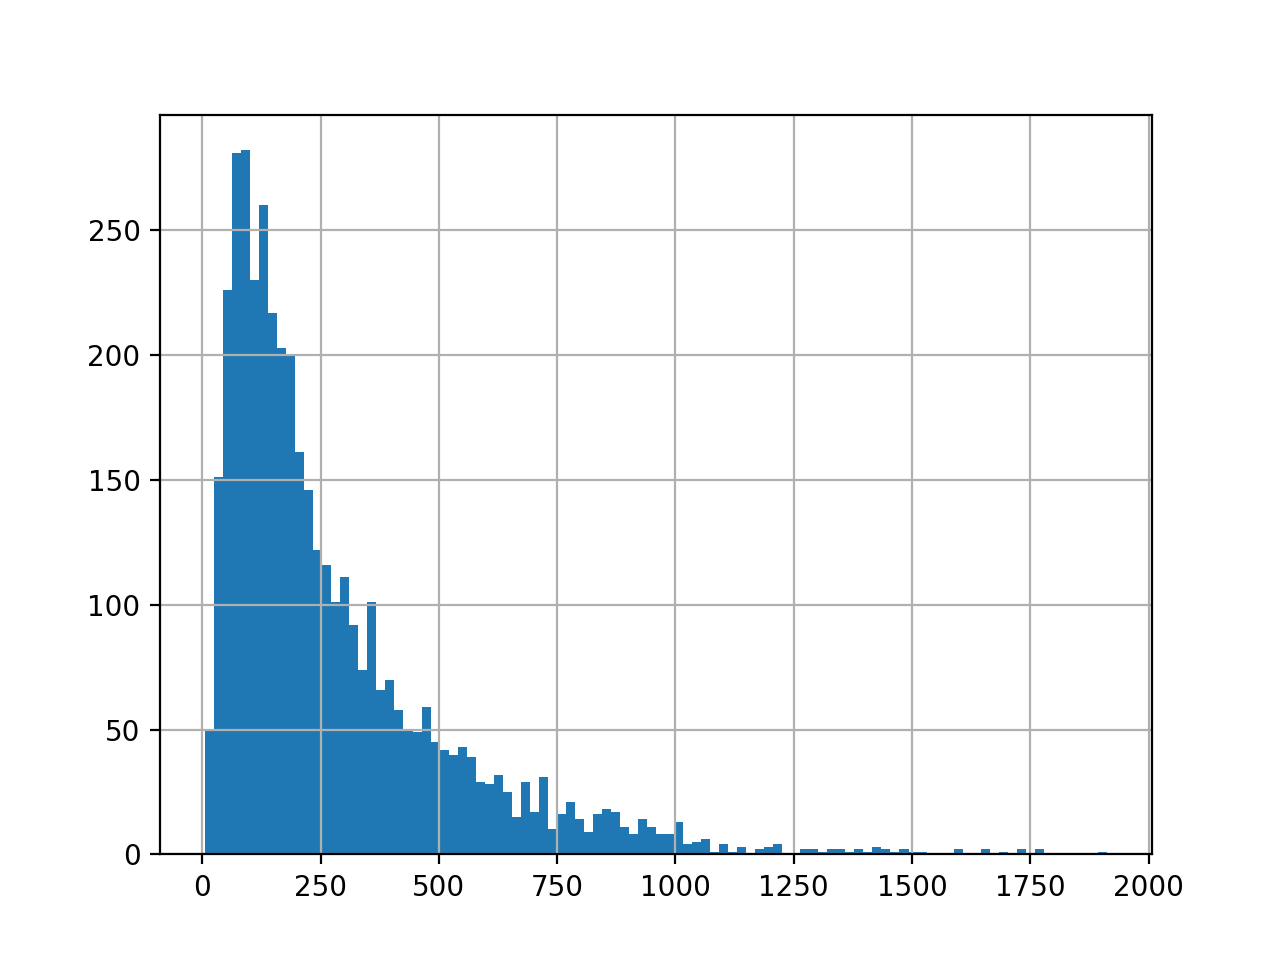

In [5]:
test.counts.hist(bins=100)

In [8]:
# Read the multiseq barcode whitelist
import pandas as pd
wl = pd.read_csv('LMOlist.csv', header=None)
wl.columns = ['a','b']
mswhite = wl.a.tolist()

In [9]:
from tqdm.notebook import tqdm
# Flatten reads for each cell based on umi (should only have one read per umi)
# Optimally this would employ some heuristic for read quality
newCells = {}
for cellid in tqdm(cells): # for each cell (by cell barcode)
    cell = cells[cellid]
    umis = []
    firstUniqueReads = []
    for read in cell: # for each read with that cell barcode, keep only unique
        if read['umi'] not in umis: 
            firstUniqueReads.append(read)
            umis.append(read['umi'])
    newCells[cellid] = firstUniqueReads
cells = newCells

In [10]:
# For each cell, count how many reads exist for each multiseq barcode (trying to assign the true batch label for that cell)
cellBarcodes = {}
for cellid in tqdm(cells):
    cell = cells[cellid]
    ms = {} # multiseq barcodes
    for read in cell:
        if read['multiseq'] in mswhite:
            if read['multiseq'] in ms:
                ms[read['multiseq']] = ms[read['multiseq']] + 1
            else:
                ms[read['multiseq']] = 1
    cellBarcodes[cellid] = ms

<IPython.core.display.Javascript object>


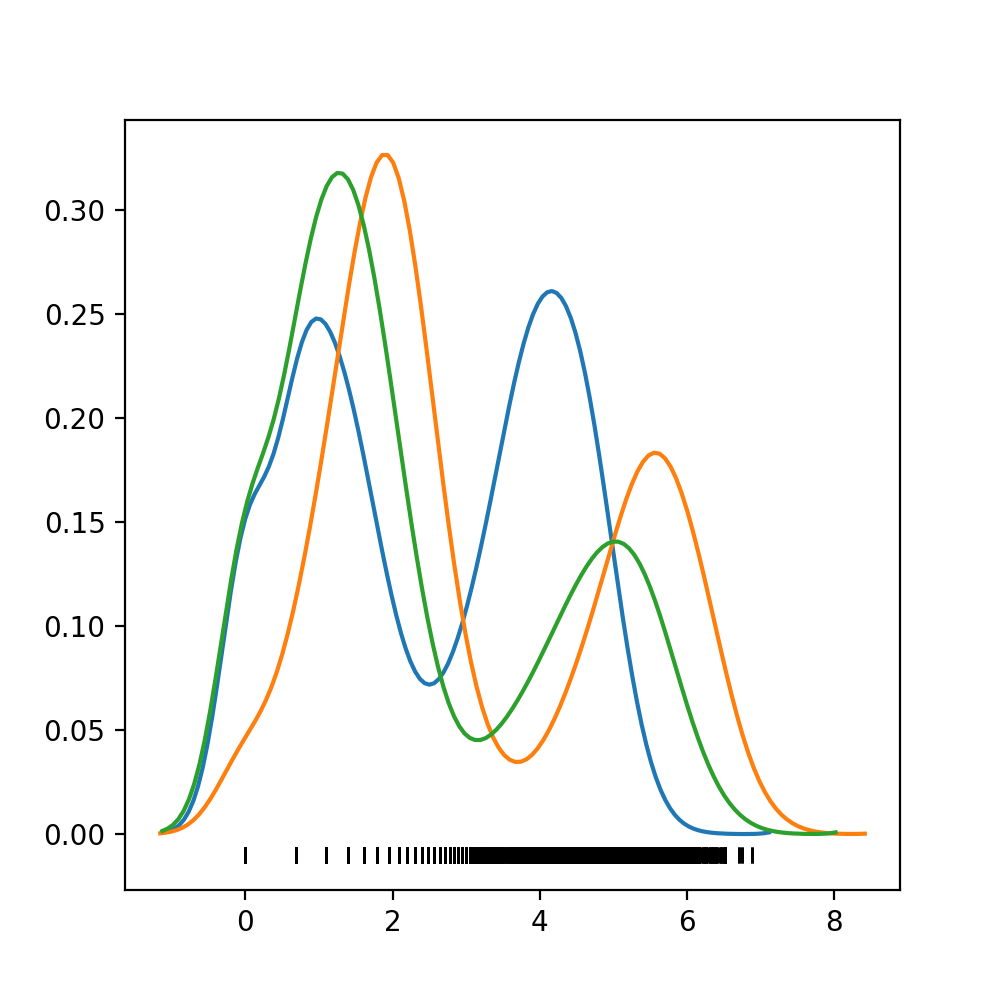

GCCAGTTA
CACTGTAG
TGCCGTGG


In [14]:
# Check the kde for each barcode to see what the distributions look like
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

targets = ['GCCAGTTA','CACTGTAG','TGCCGTGG']
f, ax = plt.subplots(figsize=(5, 5))

for target in targets:
    print(target) 
    counts = []
    for cell in cellBarcodes:
        barcodes = cellBarcodes[cell]
        for barcode in barcodes:
            if barcode == target:
                counts.append([barcodes[barcode]])

    df = pd.DataFrame({'counts':counts})            
    x = df.counts.tolist()
    x = [np.log(i[0]) for i in x]

    sns.kdeplot(x)

[1.6094379124341003]


<IPython.core.display.Javascript object>


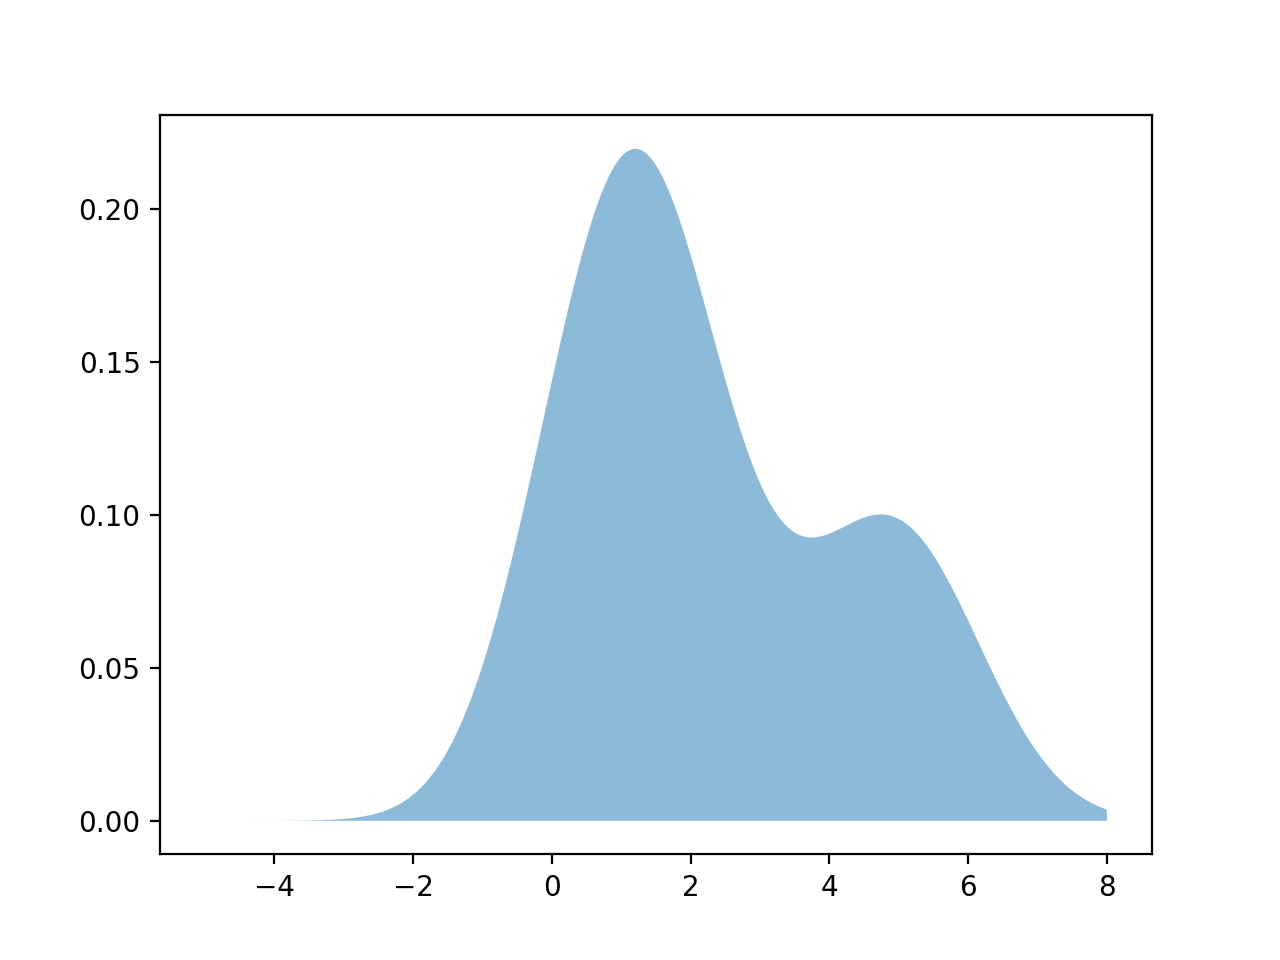

In [40]:

# Want to filter out doublets, where more than one barcode has value above threshold
from sklearn.neighbors import KernelDensity
from scipy.signal import argrelextrema

%matplotlib notebook
# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
# x = [[v] for v in x]

kde.fit(x)
x_d = np.linspace(-4-1,8,2000)

logprob = kde.score_samples(x_d[:, None])

minm = argrelextrema(np.exp(logprob), np.greater)  # (array([2, 5, 7]),)
print(x[minm[0][0]])
plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
# plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.show()
# plt.ylim(-0.02, 0.22)

# def thresholdForBarcode(targetBarcode, data):
    

# # They are all nice and bimodal; let's assign each cell a true multiseq barcode based on the max value
# for cellid in tqdm(cellbarcodes):
    
    

In [38]:
minm[0][0]

1345

<IPython.core.display.Javascript object>


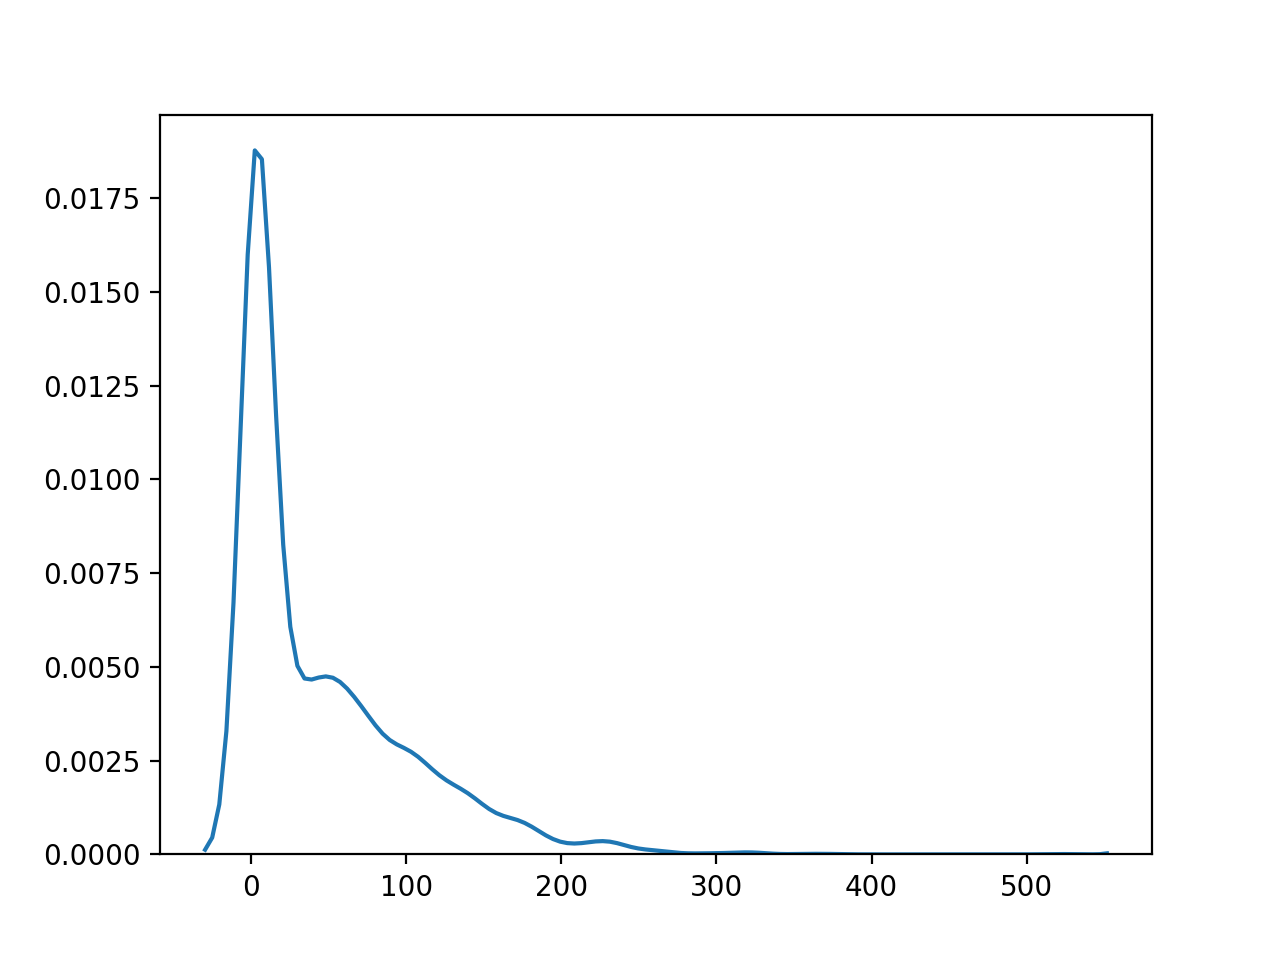